# Results

##  Goal

In this notebook we provide codes to reproduce the main results in the article, which includes the validation of the trained models and benchmarking against Bayesian inference protocols.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from src.quantum_tools import *

# Find out if this notebook is running in Google Colab
import os
isColab= 'google.colab' in str(get_ipython())

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from random import *

from qutip import *

from tqdm import tqdm
if isColab:
  from google.colab import files
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Setup and Requirements

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub.
- Install the custom pacakge

In [2]:
# Download repository if we are in Colab
if isColab:
  print('We are running in Colab. Cloning repository.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

### Import custom packages

### Data path

In [3]:
# specify the data path
datapath = 'data-test/'

Create data folder in the datapath if not already present

In [27]:
create_directory(datapath)

Directory data-test/ not found: creating...


This notebook requires the following populated folders

- `[datapath]/validation-trajectories/`
- `[datapath]/models/`
- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`

### Option #1: Downloading the data

The data that was used for the results shown in the paper can be downloaded from [Zenodo](https://zenodo.org/).
You can choose to download this data automatically by setting

 ```python
 download_required = True
 ```
 
  in the following cell. 
This will be done automatically if this notebook is run in Google Colab.


In [28]:
download_required = True

if isColab:
    download_required = True

#### Download links (Mirror 1 - Dropbox)

In [29]:
url_download_validation_trajs = "https://www.dropbox.com/scl/fi/rvpg0lmyxoqt94qu510ws/validation-trajectories.zip?rlkey=3xhp5nh4ul5ekn43xchszrqu5&dl=0"
url_download_models = "https://www.dropbox.com/scl/fi/3u8scm7vq22s9qvb1b0jo/models.zip?rlkey=qn2xtzjjwx5x57caokxbjexj5&dl=0"
url_download_results_cache = "https://www.dropbox.com/scl/fi/s31ijcmv1a7iu61y8c4sa/results_cache.zip?rlkey=o7jhr98mpzjo1vmtp4q1e06m6&dl=0"

#### Download links (Mirror 2)

Uncomment the following cell if the Dropbox links in Mirror 1 are not operative. 

Hosting of this data in Zenodo is guaranteed, although download times might be slower

In [30]:
# url_download_validation_trajs = "https://www.dropbox.com/scl/fi/rvpg0lmyxoqt94qu510ws/validation-trajectories.zip?rlkey=3xhp5nh4ul5ekn43xchszrqu5&dl=0"
# url_download_models = "https://www.dropbox.com/scl/fi/3u8scm7vq22s9qvb1b0jo/models.zip?rlkey=qn2xtzjjwx5x57caokxbjexj5&dl=0"
# url_download_results_cache = "https://www.dropbox.com/scl/fi/s31ijcmv1a7iu61y8c4sa/results_cache.zip?rlkey=o7jhr98mpzjo1vmtp4q1e06m6&dl=0"

#### Download data

In [32]:
if download_required == True:
    ! wget -q -O validation-trajectories.zip --show-progress "$url_download_validation_trajs" && unzip -q validation-trajectories.zip -d "$datapath" &&  rm validation-trajectories.zip
    ! wget -q -O models.zip --show-progress "$url_download_models" && unzip -q models.zip -d "$datapath" &&  rm models.zip
    ! wget -q -O results_cache.zip --show-progress "$url_download_results_cache" && unzip -q results_cache.zip -d "$datapath" &&  rm results_cache.zip



validation-trajecto   1%[                    ] 178,05M  16,8MB/s    eta 17m 19s

### Option #2: Populating the folders

The folders can be populated with your own data as follows.

- `[datapath]/validation-trajectories/`

    Populated by running the notebook [1-Trajectories_generation.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb)

- `[datapath]/models/`

    Populated by running the notebook [2-Training.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/2-Training.ipynb)

- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`

    Populated by running the script `uniform_2d.py`

## Load validation trajectories

### Data for 1D estimation

In [2]:
jumpsSetDelta = np.load("data/validation-trajectories/1D-delta/validation-trajectories-1D-delta-nsets-10000.npy")
deltalist = np.load("data/validation-trajectories/1D-delta/validation-deltas-1D-delta-nsets-10000.npy")
ndelta = len(deltalist)

gamma = 1
omega =1

### Data for 2D estimation

In [3]:
path_param = "data/validation-trajectories/2D-delta-omega/validation-deltas-2D-delta-omega-nsets-10000.npy"
path_tau = "data/validation-trajectories/2D-delta-omega/validation-trajectories-2D-delta-omega-nsets-10000.npy"

paramlist = np.load(path_param)
jumpsSetParams = np.load(path_tau)
nparams =  len(paramlist)

In [95]:
jumpsSetParamsBatches = np.asarray(
    [np.load(f"data/validation-trajectories/2D-delta-omega/batches/validation-trajectories-10ktrajs-batch-{idx}.npy") for idx in range(10)]
)

## Define validation functions

In [105]:
def validate_model_1D_Delays(model,nsets = 10000,jumpsSetDelta=jumpsSetDelta,deltalist=deltalist, progress_bar = True, taumax = 100):

    ndelta = len(deltalist)
    jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]


    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x
    
    MSE_list = []
    varMSE_list = []
    Estimation_list = []

    for i_delta in bar(range(ndelta)): #Bucle sobre deltas
    
        delta=deltalist[i_delta]
        
        trajectory_matrix = jumpsSetDeltaList[i_delta]
        Delta_pred = np.zeros(nsets,float)

        # Identify if we are dealing with a RNN by the input size, and reshape input matrix accordingly
        if len(model.input.shape)==3:
            trajectory_matrix = np.expand_dims(trajectory_matrix, axis = -1)
        #Delta_pred=model.predict(trajectory_matrix,verbose=0)
        Delta_pred=model(trajectory_matrix)
        
        MSE_NN = np.mean((Delta_pred-delta)**2)
        MSE_NN_var = np.var((Delta_pred-delta)**2)

        MSE_list.append(MSE_NN)
        varMSE_list.append(MSE_NN_var)
        Estimation_list.append(Delta_pred)

    return np.asarray(MSE_list), np.asarray(varMSE_list), np.asarray(Estimation_list)

def validate_model_2D_Delays(model,nsets = 10000,jumpsSetParams=jumpsSetParams,paramlist=paramlist, progress_bar = True):
    nparams = len(paramlist)
    jumpsSetList = [jumpsSet[:nsets] for jumpsSet in jumpsSetParams]

    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x  
    MSE_NN_params = []

    for i_param in bar(range(nparams)): # Loop over parameter pairs (delta,Omega)
        delta=paramlist[i_param][0]
        omega = paramlist[i_param][1]
        
        trajectory_matrix = jumpsSetList[i_param]
       
        # ============ PREDICTION ==============================
        Param_pred=np.reshape(model(trajectory_matrix),(nsets,2))
        Delta_pred = Param_pred[:,0]
        Omega_pred = Param_pred[:,1]
        # =====================================================


        diff_delta=(Delta_pred-delta)
        diff_omega=(Omega_pred-omega)
        MSE_NN = np.mean(diff_delta**2) + np.mean(diff_omega**2)

        
        MSE_NN_params.append(MSE_NN)

    MSE_NN_params = np.asarray(MSE_NN_params)
    return MSE_NN_params


## Figure 2: Classical and quantum data

### Figure 2(a-b): Evolution of a quantum trajectory and the associated posterior of $\Delta$

Create function to define a two-level system (TLS) model class (see src/bayesian.py)

Generate a list of models with different $\Delta$ values for a brute-force calculation of the Bayesian posterior

In [5]:
delta_min = 1e-3; delta_max = 4.; ndelta_Bayes = 400;

delta_grid = np.linspace(delta_min,delta_max, ndelta_Bayes)
delta_grid_Bayes = delta_grid

model_list = [create_TLS_model(delta,omega,gamma) for delta in delta_grid_Bayes]

Fix the seed of the simulation (for reproducibility)

In [6]:
seed = 44

Generate an example trajectory

In [7]:
delta = 2.; gamma = 1.; omega = 1.
model_TLS =  create_TLS_model(delta,omega,gamma)

ntraj = 1; tfin = 100.; nt = 400; tlist = np.linspace(0.,tfin,nt)
#tau_list, pops = gen_MC_jumps_from_model(model=model_TLS, tfin=tfin, ntraj=ntraj, tlistexp = tlist, seed = seed)
tau_list, pops = model_TLS.simulateTrajectories(tfin=tfin, ntraj=ntraj, tlistexp = tlist, seed = seed)

idx = 0 
taus = tau_list[idx]
pop_time = pops[idx]

Compute the posterior along the evolution of the trajectory (evaluating the likelihood over the list of different $\Delta$ values)

In [8]:
prob_delta_time = np.asarray([np.real(generate_prob_from_model_list(data = taus[np.cumsum(taus)<tfin], model_list = model_list, tfin = tfin)[:,-1]) for tfin in tqdm(tlist)])

  0%|          | 0/400 [00:00<?, ?it/s]/Users/carlos/Dropbox/La-Caixa-Junior-Leader/Fisher-information/ParamEst-PhotonCounting/src/quantum_tools.py:592: RuntimeWarning: invalid value encountered in divide
  prob_delta = likelihood_time_delta/np.sum(likelihood_time_delta,axis=0)
100%|██████████| 400/400 [00:08<00:00, 46.24it/s] 


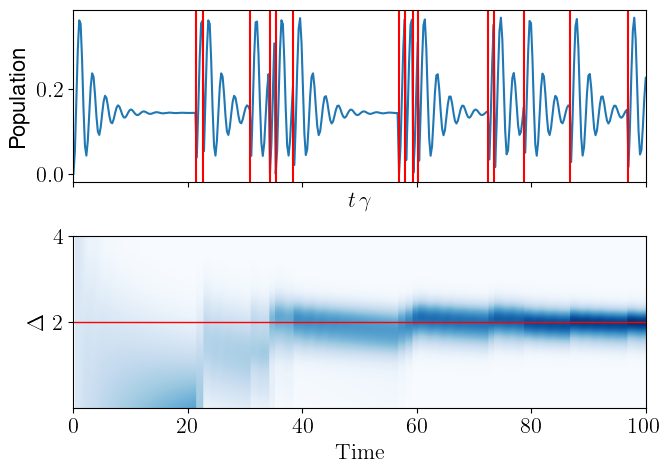

In [10]:
matrix = np.real(prob_delta_time).transpose()
aspect = 0.3

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(7,5), sharex = True)
extent = [0,tfin, delta_min,delta_max]

c = ax[0]
c.plot(tlist,pop_time)
c.set_box_aspect(aspect)
for time in np.cumsum(taus):
    c.axvline(time, color = 'red')
c.set_xlabel('$t\, \\gamma$')
c.set_ylabel('Population')

c = ax[1]
c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues" )
c.set_xlabel("$\\mathrm{Time}$"); 
c.set_ylabel("$\Delta$"); 
c.set_box_aspect(aspect)
c.axhline(delta,linewidth=1, color='r')

plt.tight_layout()
plt.show()

### Figure 2 (c)

In [11]:
Omega = 1
deltamin = 0.; deltamax = 10.; ndelta_w = 100; deltagrid = np.linspace(deltamin,deltamax,ndelta_w)
paramList  = [[Omega, Delta] for Delta in deltagrid]
taumax = 10.; ntau = 500;
taulist = np.linspace(0,taumax,ntau)

wtaumatrix = np.asarray([compute_waiting_time_list(params, taulist) for params in paramList])
poplist = np.asarray([compute_population_ss(params) for params in paramList])


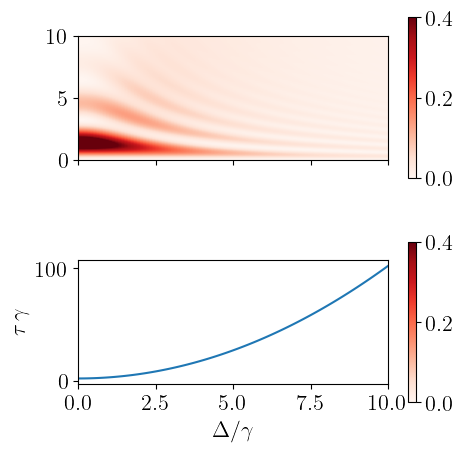

In [12]:
aspect = 0.4
matrix = wtaumatrix.T
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(5,5), sharex = True,gridspec_kw={'height_ratios': [2,2], 'hspace': 0.4})
extent = [deltamin, deltamax,0,taumax]

c = ax[0]
vmax = 0.4
from matplotlib import colors
wtaunorm=colors.TwoSlopeNorm(vmin=0, vcenter=vmax/2, vmax=vmax)

pcm=c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], norm=wtaunorm,cmap="Reds", origin = 'lower' )
fig.colorbar(pcm, ax=c,location='right')
fig.colorbar(pcm, ax=ax[1],location='right')

c = ax[1]
c.plot(deltagrid,1/np.real(poplist))
#c.set_ylim(0,0.5)
c.set_ylabel("$\\langle T \\rangle \\gamma/N$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 
c.set_box_aspect(aspect)



c.set_ylabel("$\\tau\, \\gamma$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 
c.set_box_aspect(aspect)



plt.show()

### Figure 2(e): Histograms of time delays 

In [13]:
nsetsplot = 30
i_delta = 5

trajectories_plot=jumpsSetDelta[i_delta][:nsetsplot]

#Turn into histogram
nbins = 50
taumaxplot=10
bins = np.linspace(0,taumaxplot,nbins)

histogram_list = np.zeros([len(trajectories_plot), nbins-1])
for idx, delays in enumerate(trajectories_plot):
    histogram_list[idx] = np.histogram(delays,bins=bins)[0]
histogram_list = np.asarray(histogram_list)

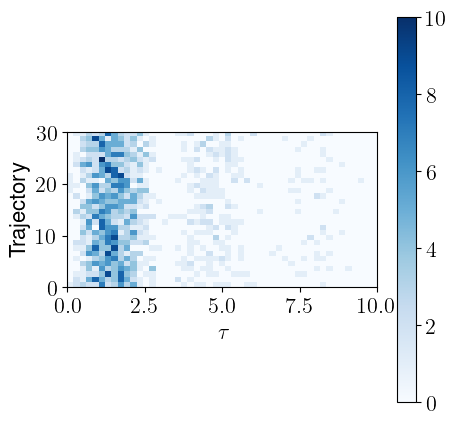

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
aspect = 0.5
extent=[0,taumaxplot,0,nsetsplot]
pcm = ax.imshow(histogram_list, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues" )
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Trajectory")
ax.set_box_aspect(aspect)
fig.colorbar(pcm, ax=ax,location='right')
plt.show()

### Figure 2(d)

In [15]:
i_delta = 5
tfin_list = np.sum(jumpsSetDelta[i_delta],axis = 1)

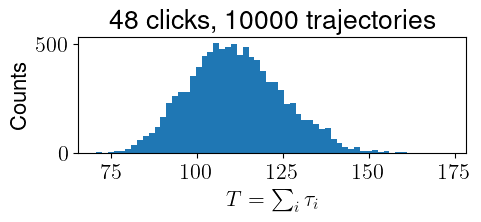

In [16]:
fix, ax = plt.subplots(figsize = (5,3))
ax.hist(tfin_list, bins = 60, density = False)
ax.set_xlabel('$T = \sum_i \\tau_i$')
ax.set_ylabel('Counts')
ax.set_box_aspect(0.3)
ax.set_title(f"48 clicks, {len(jumpsSetDelta[i_delta])} trajectories ")
plt.show()

## Figure 3: Benchmarking models for 1D parameter estimation

### Classical estimation

In [9]:
import numpy as np

def delta_pred_TLS(T:float, Omega:float, gamma:float, n:float)-> float:
    """
    Calculate the predicted value of delta assuming that the number of clicks follows a Poissonian distribution with a mean given by the TLS population.

    Parameters:
    T: Total evolution time.
    Omega: Rabi frequency of the drive.
    gamma: Spontaneous emission rate.
    n: Number of clicks.

    Returns:
    float: Predicted delta value.
    """
    # Convert the input temperatures to complex numbers
    T = T.astype(complex)
    
    # Calculate the predicted delta using the TLS model formula
    delta = np.real(
        np.sqrt((4 * T * gamma * Omega**2 - n * (gamma**2 + 8 * Omega**2))) /
        (2 * np.sqrt(n))
    )
    
    return delta


In [10]:
njumps = jumpsSetDelta.shape[2]
nsets = jumpsSetDelta.shape[1]

MSE_Class = []
Estimation_list = []
ndelta = len(deltalist)

for i_delta in range(ndelta): # Loop over deltas
    
    delta=deltalist[i_delta]
    jumpsSet = jumpsSetDelta[i_delta]
    Delta_pred = np.zeros(nsets,float)
    # We sum over all the delays to get a list of final times
    tflist=np.sum(jumpsSet,axis =1) 
 
    for i in range(0,nsets): # Loop over sets
        n_mean=njumps
        tfinal = tflist[i]
        Delta_pred[i] = delta_pred_TLS(tfinal, omega, gamma, n_mean)

    MSE = np.mean((Delta_pred-delta)**2)
    MSE_Class.append(MSE)
    Estimation_list.append(Delta_pred)

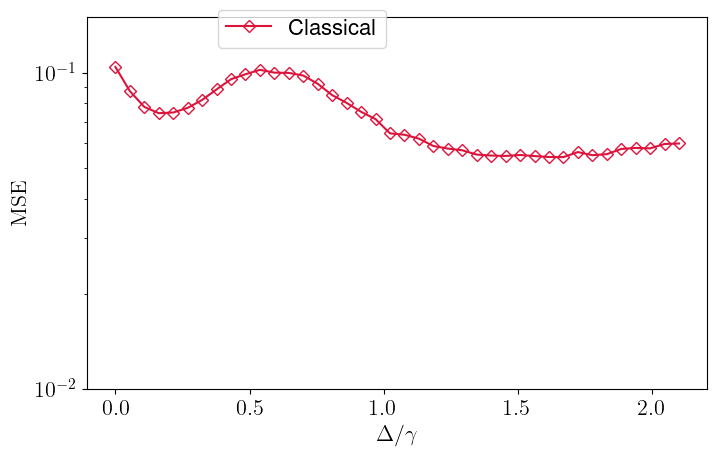

In [11]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Bayesian estimation

In [12]:
max_cpus=19
qutip.settings.num_cpus = max_cpus

nsets = 10000
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

path_cached_results = 'data/results_cache/bayesian_estimation/1D/estimationBayes1D.npy'

if not os.path.isfile(path_cached_results):
    print("Estimation not found: Computing.")

    estimate_array_delta = []

    for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas


        delta=deltalist[i_delta]

        trajectory_matrix = jumpsSetDeltaList[i_delta]

        Delta_pred = np.zeros(nsets,float)
        estimate_array = parallel_map(get_estimates,trajectory_matrix)
        estimate_array_delta.append(estimate_array)

    estimate_array_delta = np.asarray(estimate_array_delta)
    estimationsBayes1D = estimate_array_delta[:,:,0]
    np.save(path_cached_results,estimationsBayes1D) 

else:
    estimationsBayes1D = np.load(path_cached_results)


In [13]:
MSE_Bayes_Mean = np.array([np.mean((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])
varMSE_Bayes_Mean = np.array([np.var((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])

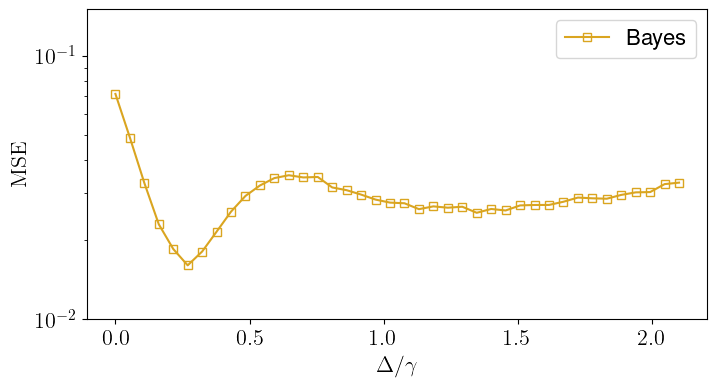

In [14]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### RNN model 

In [16]:
model=model=keras.models.load_model("data/models/1D/model-RNN-dense.h5", compile=False)

In [17]:
MSE_RNN, varMSE_RNN, estimationsRNN = validate_model_1D_Delays(model)

100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


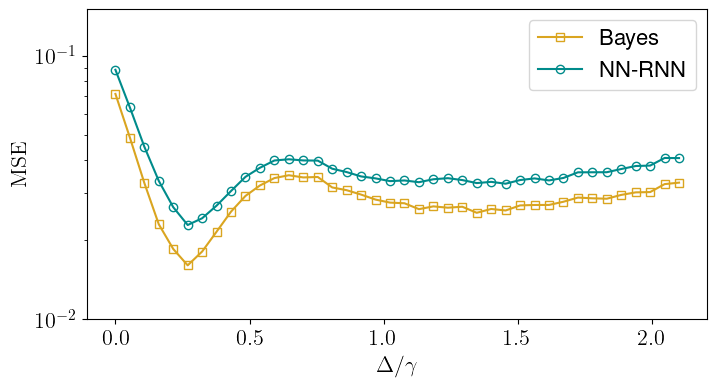

In [18]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN, 'o-',  label= "NN-RNN",color = "darkcyan",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Hist-Dense model

In [27]:
from src.custom_layers import MyHistogramLayer_Sigmoid, histogram_sigmoid

Load model

In [28]:
modelname = 'model-Hist.h5'
modelHist=keras.models.load_model(f"data/models/1D/{modelname}", compile=False)

In [29]:
MSE_Hist, varMSE_hist, estimationsHist = validate_model_1D_Delays(modelHist)

100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


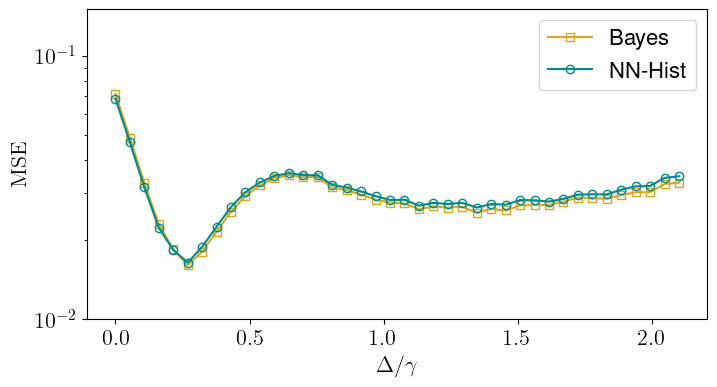

In [30]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')
#ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Plotting all together

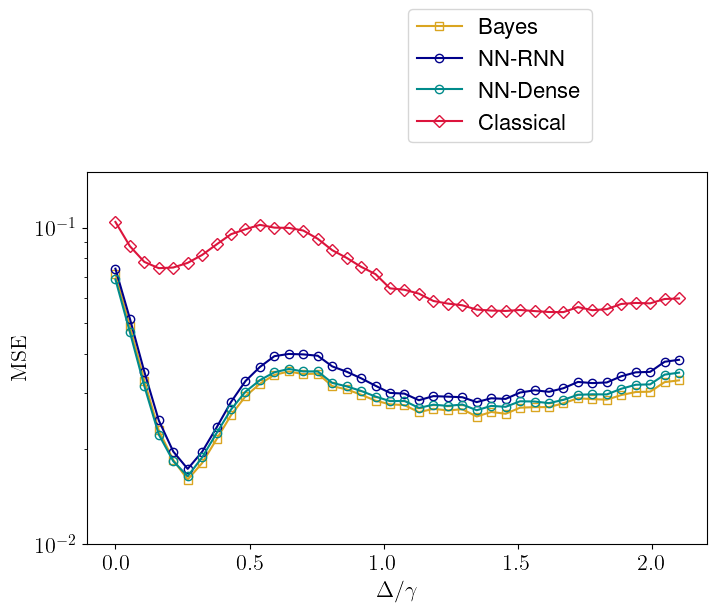

In [31]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Quantum Fisher information

In [34]:
def L_fun(omega, gamma, delta):
    'Returns Liouvillian for the two-level system model'
    return np.array([[0, 1j * omega, -1j * omega, gamma],
                    [1j * omega, -gamma/2 + 1j * delta, 0, -1j * omega],
                    [-1j * omega, 0, -gamma/2 - 1j * delta, 1j * omega],
                    [0, -1j * omega, 1j * omega, -gamma ]])


# Derivative of generalized Liouvillian with respect to theta_1
m1 = np.array([[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, -1j, 0],
               [0, 0, 0, -1j]])

# Derivative of generalized Liouvillian with respect to theta_2
m2 = np.array([[0, 0, 0, 0],
               [0, 1j, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 0, 1j]])

# Parameters
omega_sel = 1
gamma_sel = 1
delta_grid = deltalist

# Initialize derivatives list
der_list = []
identityVec = np.eye(2).flatten()

# Perform computation for each delta_sel
for delta_sel in delta_grid:
    umatrix = np.zeros((4,4), dtype = complex)

    Lsel = L_fun(omega_sel, gamma_sel, delta_sel)
    eigenvalues, eigenvectors = np.linalg.eig(Lsel)
    sorted_indices = np.argsort(eigenvalues.real)  # Sort eigenvalues in ascending order of real part
    eigenvalues = eigenvalues[sorted_indices]

    for i in range(4):
        umatrix[i] = eigenvectors[:, sorted_indices[i]]
    vmatrix = (np.linalg.inv(umatrix)).T

    # Normalized steady state
    rho_ss = umatrix[3] / (umatrix[3]@identityVec)
    sum1 = 0
    sum2 = 0
    for i in range(3):
        sum1 = sum1 + ((vmatrix[i] / eigenvalues[i]) @ m2 @ rho_ss) * umatrix[i]
        sum2 = sum2 + ((vmatrix[i] / eigenvalues[i]) @ m1 @ rho_ss) * umatrix[i]

    lambda_ij = (-m1@sum1 - m2@sum2)@ identityVec
    der_list.append(lambda_ij)  # Append the computed QFI

In [35]:
popGrid = np.asarray([compute_population_ss([omega, delta]) for delta in delta_grid])
Tgrid = 48/popGrid
QFI_list = 4*Tgrid*der_list

/Users/carlos/miniforge3/envs/PITest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


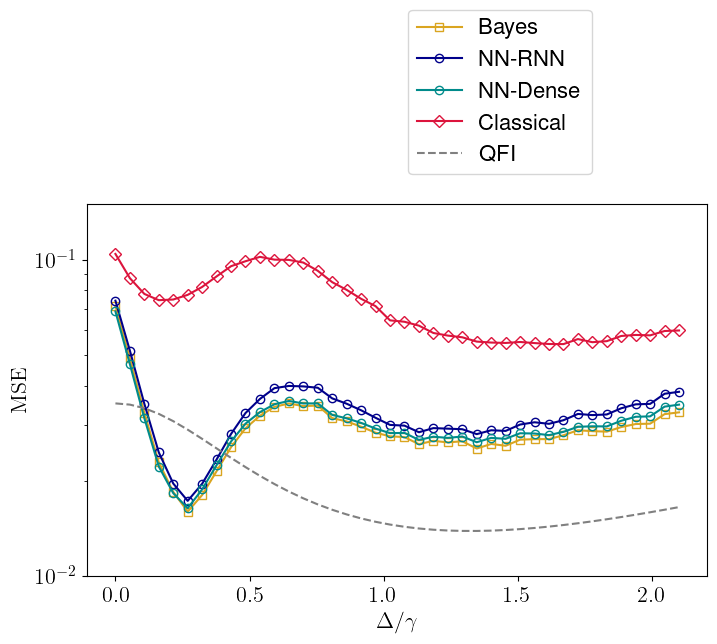

In [36]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,1/QFI_list, '--',  label= "QFI", color = "gray",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Fisher information for Photon Counting

In [37]:
def der2_trajectory(delta,tau_list):
    epsilon = 0.001
    logptheta1=np.log(compute_likelihood_analytical(delta,tau_list))
    logptheta2=np.log(compute_likelihood_analytical(delta+epsilon,tau_list))
    dptheta = (logptheta2-logptheta1)/epsilon
    return dptheta**2

def get_Fisher_Information_derivative(i_delta):
    trajectory_matrix = jumpsSetDelta[i_delta]
    delta_sel = deltalist[i_delta]
    der2_list = np.asarray([der2_trajectory(delta_sel,tau_list) for tau_list in trajectory_matrix])
    return np.mean(der2_list)


In [38]:
fisherIdelta = np.asarray(parallel_map(get_Fisher_Information_derivative,range(len(deltalist)), progress_bar=True))

10.0%. Run time:  11.19s. Est. time left: 00:00:01:40
20.0%. Run time:  11.28s. Est. time left: 00:00:00:45
30.0%. Run time:  11.30s. Est. time left: 00:00:00:26
40.0%. Run time:  11.38s. Est. time left: 00:00:00:17
50.0%. Run time:  22.53s. Est. time left: 00:00:00:22
60.0%. Run time:  22.74s. Est. time left: 00:00:00:15
70.0%. Run time:  22.80s. Est. time left: 00:00:00:09
80.0%. Run time:  22.85s. Est. time left: 00:00:00:05
90.0%. Run time:  22.92s. Est. time left: 00:00:00:02
100.0%. Run time:  28.25s. Est. time left: 00:00:00:00
Total run time:  28.26s


/Users/carlos/miniforge3/envs/PITest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


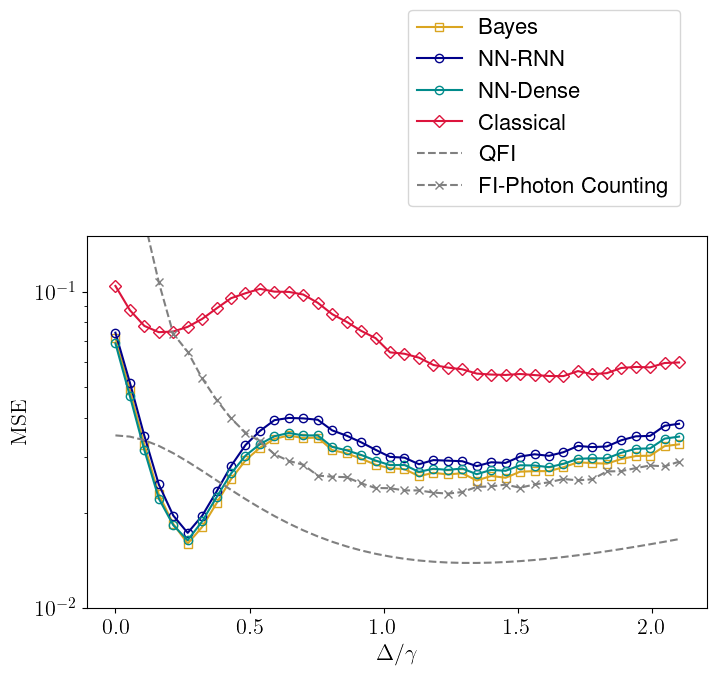

In [40]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,1/QFI_list, '--',  label= "QFI", color = "gray",markerfacecolor='none')
ax.plot(deltalist[1:],1/fisherIdelta[1:], 'x--',  label= "FI-Photon Counting", color = "gray",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

## Figure 4: Benmachrking for 2D estimation

### Bayesian estimation

In [34]:
if isColab:
  print("Running in Google Colab.")

We work with data that has been saved in different batches (for parallelization). 
In our case, we have saved the validation trajectories in 10 different batches.
The number of batches was set in "1-Trajetories-generation.ipynb".

In [50]:
# Number of parameter pairs that were simulated for validation
nparams = 1600

# Number of trajectories that were simulated per parameter pair
nsets = 10000

# Number of batches in which the trajectories were divided 
nbatches = 10

# Number of trajectories per batch that correspond to a specific parameter pair
traj_per_param_pair = int(nsets/nbatches)

We define some functions to handle this data and output the corresponding predictions

In [51]:
def load_preds(idx_data:int):
    '''
    Loads from file the result of a Bayesian inference procedure computed with ultranest.
    This function requires a populated "data/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest" folder.

    Each batch corresponds to a number (nsets/nbatches) of trajectories for each of the 1600 parameter pairs.
    Therefore, the this function will return (nsets/nbatches)x1600 predictions.

    Parameters
    ----------
    idx_data (int): Integer number that labels the batch to be loaded. It assumes a folder populated with data with the format "uniform_2d_all_{idx_data}.csv".

    Returns
    ----------
    List of two np.arrays with the predictions for omega and delta respectively by using the mean as the estimator.
    '''
    data = pd.read_csv(f"data/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest/uniform_2d_all_{idx_data}.csv")
    nparams = len(paramlist)
    omega_preds_mean=np.array(data[data.params=="omega"].iloc[:,0])
    delta_preds_mean=np.array(data[data.params=="delta"].iloc[:,0])

    return omega_preds_mean, delta_preds_mean


def select_prediction_param(i_param:int, pred_list_from_batch: list, traj_per_param_pair:int):
    '''
    Giving the list of predictions from a single batch, this function selects those corresponding to trajectories that were generated from a
    specific parameter pair, indexed by "i_param". This pair corresponds to the true value of the parameters, while this function will output the corresponding predictions.
    The number of predictions selected is given by "traj_per_param_pair".

    Parameters
    ----------
    i_param (int): Index characterizing the parameter-pair (Delta,Omega) of the trajectories to be analized.
    pred_list_from_batch (list): Full list of predictions from a single batch of data
    traj_per_param_pair (int): Number of trajectories corresponding to a single parameter-pair in each batch

    Returns
    ----------
    List of predictions corresponding only to the trajectories obtained from the parameter-pair with index "i_param"
    '''
    return list(pred_list_from_batch[(i_param)*traj_per_param_pair:(i_param+1)*traj_per_param_pair])

Load predictions

In [52]:
prediction_list = [load_preds(idx_data) for idx_data in tqdm(range(nbatches))]

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Save them as numpy files

In [56]:
def path_save_idx(idx_data):
    return f"data/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest/uniform_2d_predictions_{idx_data}"

[ np.save(
    path_save_idx(idx_data),np.asarray(prediction_list_batch) ) 
    for idx_data, prediction_list_batch in enumerate(prediction_list)]

[None, None, None, None, None, None, None, None, None, None]

We now compare the predictions with the true parameters and compute the covariance matrix

In [89]:
MSE_Bayes2D = []

# Compute the covariance matrix

for i_param in tqdm(range(nparams)): # Loop over parameter-pairs

    delta=paramlist[i_param][0]
    omega = paramlist[i_param][1]
    params = np.array(paramlist[i_param])

    deltas_pred_mean_ALL = []
    omega_pred_mean_ALL = []

    for idx_batch in range(nbatches):
        omega_preds_mean, delta_preds_mean = prediction_list[idx_batch]
        
        deltas_pred_mean_ALL+=select_prediction_param(i_param, delta_preds_mean, traj_per_param_pair)
        omega_pred_mean_ALL+=select_prediction_param(i_param, omega_preds_mean, traj_per_param_pair)

    diff_delta=(deltas_pred_mean_ALL-params[0])
    diff_omega=(omega_pred_mean_ALL-params[1])
    
    MSE = np.mean(diff_delta**2) + np.mean(diff_omega**2)
    MSE_Bayes2D.append(MSE)

MSE_Bayes2D = np.asarray(MSE_Bayes2D)


100%|██████████| 1600/1600 [00:01<00:00, 1069.19it/s]


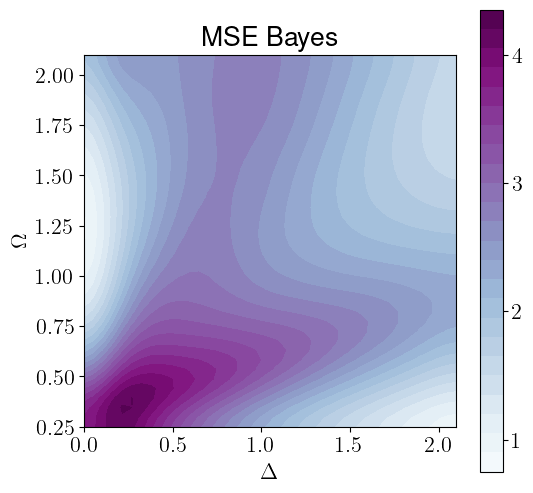

In [93]:
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter

levels = 4
deltaGrid = np.sort(np.unique(paramlist[:,0]))
OmegaGrid = np.sort(np.unique(paramlist[:,1]))
XX, YY = np.meshgrid(deltaGrid,OmegaGrid)

MSE_Bayes_matrix = MSE_Bayes2D.reshape(40,40)
MSE_Bayes_matrix = gaussian_filter(MSE_Bayes_matrix,sigma = 2)

fig, axis = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

ax = axis
pcm=ax.contourf(XX,YY,-np.log(MSE_Bayes_matrix),cmap='BuPu',levels = 30)

cbar = fig.colorbar(pcm, ax=ax)
ticks = [1,2,3,4]
# Define your desired tick values
# Create a ticker object with your desired tick values
ticker_obj = ticker.FixedLocator(ticks)
# Set the ticker object for the colorbar
cbar.locator = ticker_obj
# Update the ticks and labels on the colorbar
cbar.update_ticks()
ax.set_box_aspect(1)
ax.set_title("MSE Bayes")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")



plt.show()

### Hist-Dense model

In [106]:
from src.custom_layers import MyHistogramLayer_Sigmoid
modelname = "model-Hist-Dense-2D"
model=keras.models.load_model("data/models/2D/"+modelname+'.h5', compile=False);

In [107]:
nsets = 10000 # Trajs. per parameter
path_results_model2D = f"data/results_cache/bayesian_estimation/2D/estimationNN/estimation-{modelname}"
isNCovNfile=os.path.isfile(path_results_model2D+".npy")

if isCovNNfile:
    covNN_params = np.load(path_results_model2D)
else:
    covNN_params = validate_model_2D_Delays(model,nsets = nsets,jumpsSetParams=jumpsSetParams,paramlist=paramlist, progress_bar = True)
    np.save(path_results_model2D,covNN_params) 

 80%|████████  | 1288/1600 [22:19<05:25,  1.04s/it]

In [104]:
np.save(path_results_model2D,covNN_params) 

## Figure 5: Robustness against noise

### Noise in x-train

- This evaluation requires a populated `data/models/1D/noise-x-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-x-train`

In [41]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

For this test, we select a particular value of delta from the validation set.


In [42]:
i_delta = 5 
delta = deltalist[i_delta]
trajectory_matrix = jumpsSetDelta[i_delta]

We loop over $\sigma$, addding noise to the validation trajectories. We make predictions using the corresponding model trained with data with the same noise, and also make a Bayesian estimation with a model that does not account for noise.

In [ ]:
mse_sigma = []
mse_sigma_NN = []
estimate_Bayes_array = []
estimate_NN_array = []
varMSE_Bayes_array = []
varMSE_NN_array = []

seed = 1
# nsets can be as high as 10k (the total number of validation trajectories per delta value)
nsets = 1000

for sigma in tqdm(sigma_list):
    noise = np.random.default_rng(seed).normal(0.,sigma, trajectory_matrix.shape)
    trajectory_matrix_noise = ((trajectory_matrix + noise).clip(min=1E-3))[:nsets]

    estimate_array = np.array(parallel_map(get_estimates,trajectory_matrix_noise))
    estimate_Bayes_array.append(estimate_array)
    est_mean_anal = estimate_array[:,0]
    mse_mean = np.mean((est_mean_anal - delta)**2)
    varMSE = np.var((est_mean_anal - delta)**2)
    mse_sigma.append(mse_mean)
    varMSE_Bayes_array.append(varMSE)

    model=keras.models.load_model(f"data/models/1D/noise-x-train/model_best_Hist-sigma_{sigma}.hdf5",compile=False)
    estimate_array= np.asarray(model(trajectory_matrix_noise)).flatten()
    estimate_NN_array.append(estimate_array)

    mse = np.mean((estimate_array - delta)**2)
    varMSE = np.var((estimate_array - delta)**2)
    mse_sigma_NN.append(mse)
    varMSE_NN_array.append(varMSE)

mse_sigma = np.asarray(mse_sigma)
mse_sigma_NN = np.asarray(mse_sigma_NN)
estimate_NN_array = np.asarray(estimate_NN_array)
estimate_Bayes_array = np.asarray(estimate_Bayes_array)
varMSE_Bayes_array = np.asarray(varMSE_Bayes_array)
varMSE_NN_array = np.asarray(varMSE_NN_array)


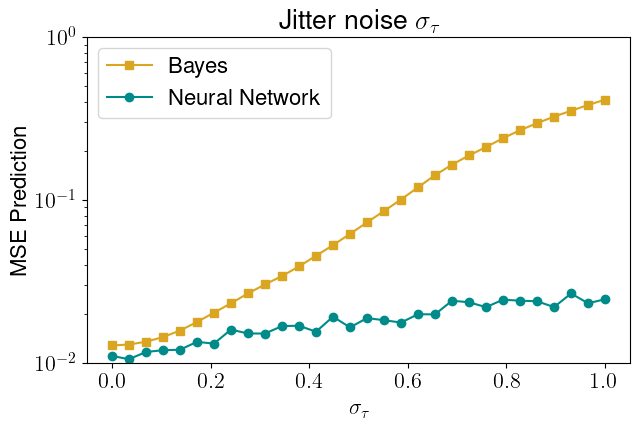

In [202]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(sigma_list,mse_sigma, 's-',label= 'Bayes', color = "goldenrod")
ax.plot(sigma_list,mse_sigma_NN,'o-', label= 'Neural Network', color = "darkcyan")
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,1)
plt.xlabel("$\\sigma_\\tau$"); plt.ylabel("MSE Prediction"); 
plt.title('Jitter noise $\sigma_\\tau$')
plt.yscale('log')
plt.legend()
plt.show()

### Noise in the y-train

- This evaluation requires a populated `data/models/1D/noise-y-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-y-train`

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

For this test, we select a particular value of delta from the validation set.


In [ ]:
i_delta = 5 
delta = deltalist[i_delta]
trajectory_matrix = jumpsSetDelta[i_delta]

We compute the Bayesian reference

In [ ]:
nsetsBayes = 1000
estimate_array = np.array(parallel_map(get_estimates,trajectory_matrix[:nsetsBayes]))
est_mean_anal = estimate_array[:,0]
mse_Bayes = np.mean((est_mean_anal - delta)**2)

We loop over $\sigma$, evaluating the predictions made with noise in the target data. 

In [ ]:
mse_sigma = []
mse_sigma_NN = []
varMSE_sigma_NN = []
estimate_Calibration_Array = []
estimate_NN_array = []

for sigma in tqdm(sigma_list):
    noise = np.random.default_rng(seed).normal(0.,sigma,nsets)

    # This array is replicates the noise in the training. 
    estimate_array = delta + noise
    estimate_Calibration_Array.append(estimate_array)
    mse_mean = np.mean((estimate_array - delta)**2)
    mse_sigma.append(mse_mean)

    model=keras.models.load_model(f"data/models/1D/noise-y-train/model_best_Hist-sigma_{sigma}.hdf5", compile=False)
    estimate_array= np.asarray(model(trajectory_matrix)).flatten()
    estimate_NN_array.append(estimate_array)

    mse = np.mean((estimate_array - delta)**2)
    varMSE = np.var((estimate_array - delta)**2)
    mse_sigma_NN.append(mse)
    varMSE_sigma_NN.append(varMSE)

mse_sigma = np.asarray(mse_sigma)
mse_sigma_NN = np.asarray(mse_sigma_NN)
estimate_NN_array = np.asarray(estimate_NN_array)
estimate_Calibration_Array = np.asarray(estimate_Calibration_Array)
varMSE_sigma_NN = np.asarray(varMSE_sigma_NN)

100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


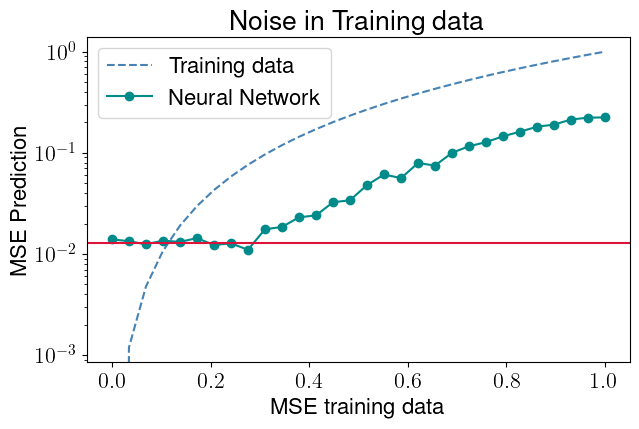

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(sigma_list, sigma_list**2, '--',color='steelblue', label="Training data")
ax.plot(sigma_list,mse_sigma_NN,'o-', label= 'Neural Network', color = "darkcyan")

ax.axhline(mse_Bayes, color='crimson')
ax.set_box_aspect(0.6)
plt.xlabel("MSE training data"); plt.ylabel("MSE Prediction"); 
plt.title('Noise in Training data')
plt.yscale('log')
plt.legend()
plt.show()